In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
import string
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
def load_and_prepare_data():
    """Load breast cancer dataset and prepare for training"""
    # Load dataset
    data = load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names

    print("="*60)
    print("DATASET INFORMATION")
    print("="*60)
    print(f"Total samples: {X.shape[0]}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Classes: {data.target_names}")

    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls} ({data.target_names[cls]}): {count} samples ({100*count/len(y):.1f}%)")

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print(f"\nDataset splits:")
    print(f"  Training: {X_train.shape[0]} samples")
    print(f"  Validation: {X_val.shape[0]} samples")
    print(f"  Test: {X_test.shape[0]} samples")
    print("="*60)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, feature_names

X_train, X_val, X_test, y_train, y_val, y_test, scaler, feature_names = load_and_prepare_data()

DATASET INFORMATION
Total samples: 569
Number of features: 30
Classes: ['malignant' 'benign']

Class distribution:
  Class 0 (malignant): 212 samples (37.3%)
  Class 1 (benign): 357 samples (62.7%)

Dataset splits:
  Training: 410 samples
  Validation: 73 samples
  Test: 86 samples


In [ ]:
class FlexibleNN(nn.Module):
    """Flexible neural network for high-dimensional binary classification"""
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.3, device='cpu'):
        super(FlexibleNN, self).__init__()
        self.device = device

        layers = []
        prev_dim = input_dim

        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 2))

        self.network = nn.Sequential(*layers)
        self.to(device)

    def forward(self, x):
        return self.network(x)

    def predict_proba(self, x):
        """Get probability predictions"""
        self.eval()
        with torch.no_grad():
            if isinstance(x, np.ndarray):
                x = torch.tensor(x, dtype=torch.float32).to(self.device)
            else:
                x = x.to(self.device)
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
        return probs.cpu()

    def predict(self, x):
        """Get class predictions"""
        probs = self.predict_proba(x)
        return torch.argmax(probs, dim=1)

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.001, batch_size=32):
    """Train the neural network model"""

    # Prepare data
    train_data = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

    train_losses = []
    val_losses = []

    print("\nTraining Progress:")
    print("-" * 40)

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)

        train_loss /= len(X_train)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_x = torch.tensor(X_val, dtype=torch.float32).to(device)
            val_y = torch.tensor(y_val, dtype=torch.long).to(device)
            val_outputs = model(val_x)
            val_loss = criterion(val_outputs, val_y).item()
            val_losses.append(val_loss)

        scheduler.step(val_loss)

        if epoch % 20 == 0 or epoch == epochs-1:
            val_acc = (model.predict(val_x).cpu() == val_y.cpu()).float().mean()
            print(f"Epoch {epoch:3d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_losses

# Initialize and train model
print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

input_dim = X_train.shape[1]
model = FlexibleNN(input_dim, hidden_dims=[256, 128, 64, 32], dropout_rate=0.2, device=device)

train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, epochs=150)

# Evaluate model
model.eval()
with torch.no_grad():
    test_pred = model.predict(torch.tensor(X_test, dtype=torch.float32))
    test_acc = (test_pred.numpy() == y_test).mean()

print("-" * 40)
print(f"Final Test Accuracy: {test_acc:.4f}")
print("="*60)


MODEL TRAINING

Training Progress:
----------------------------------------
Epoch   0: Train Loss=0.4548, Val Loss=0.4503, Val Acc=0.9726
Epoch  20: Train Loss=0.0751, Val Loss=0.0404, Val Acc=0.9863
Epoch  40: Train Loss=0.0618, Val Loss=0.0686, Val Acc=0.9589
Epoch  60: Train Loss=0.0339, Val Loss=0.0352, Val Acc=1.0000
Epoch  80: Train Loss=0.0304, Val Loss=0.0383, Val Acc=1.0000
Epoch 100: Train Loss=0.0178, Val Loss=0.0385, Val Acc=1.0000
Epoch 120: Train Loss=0.0352, Val Loss=0.0453, Val Acc=1.0000
Epoch 140: Train Loss=0.0402, Val Loss=0.0474, Val Acc=1.0000
Epoch 149: Train Loss=0.0287, Val Loss=0.0424, Val Acc=1.0000
----------------------------------------
Final Test Accuracy: 0.9651


In [ ]:
accuracy = lambda x, y: np.mean(model.predict(x).numpy() == y)
print("Train accuracy:", accuracy(X_train, y_train))
print("Val accuracy:", accuracy(X_val, y_val))
print("Test accuracy:", accuracy(X_test, y_test))

Train accuracy: 1.0
Val accuracy: 1.0
Test accuracy: 0.9651162790697675


In [ ]:
def fgsm_high_dim(model, sample, epsilon=0.005, max_steps=1000):
    """FGSM for high-dimensional inputs"""
    device = next(model.parameters()).device
    sample_tensor = torch.tensor(sample, dtype=torch.float32, device=device)
    if sample_tensor.ndim == 1:
        sample_tensor = sample_tensor.unsqueeze(0)

    # class predicted at the start
    orig_pred = model.predict(sample_tensor).item()

    for _ in range(max_steps):
        # Create a fresh tensor with requires_grad for this iteration
        perturbed = sample_tensor.clone().detach().requires_grad_(True)

        # forward + loss on the current predicted class
        logits = model(perturbed)
        target = torch.tensor([orig_pred], dtype=torch.long, device=device)
        loss = nn.CrossEntropyLoss()(logits, target)

        # backprop to get ∂loss/∂x
        loss.backward()

        # FGSM *maximizes* loss → move in +sign(grad)
        with torch.no_grad():
            sample_tensor = sample_tensor + epsilon * perturbed.grad.sign()

        # stop once the class flips
        new_pred = model.predict(sample_tensor).item()
        if new_pred != orig_pred:
            break

    return sample_tensor.detach().cpu().numpy().squeeze()

def cmaes_high_dim(model, sample, n_generations=100, population_size=None, sigma=0.5):
    """CMA-ES for high-dimensional decision boundary finding"""
    try:
        import cmaes
    except ImportError:
        print("Installing cmaes...")
        import subprocess
        subprocess.check_call(["pip", "install", "cmaes"])
        import cmaes

    n_dims = len(sample)
    if population_size is None:
        population_size = 4 + int(3 * np.log(n_dims))

    # Define objective function
    def objective(x):
        probs = model.predict_proba(x.reshape(1, -1)).numpy()[0]
        # Minimize difference from uniform distribution (0.5, 0.5)
        uniformity_loss = np.sum(np.abs(probs - 0.5))
        # Add small distance penalty
        distance = np.linalg.norm(x - sample)
        return uniformity_loss + 0.01 * distance

    # Run CMA-ES
    optimizer = cmaes.CMA(mean=sample, sigma=sigma, population_size=population_size)

    for generation in range(n_generations):
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            value = objective(np.array(x))
            solutions.append((x, value))

        optimizer.tell(solutions)

        if optimizer.should_stop():
            break

    # Get best solution
    best_solution = min(solutions, key=lambda x: x[1])[0]
    return np.array(best_solution)

In [ ]:
def create_comparison_visualization(sample_points, cmaes_points, fgsm_points,
                                   sample_labels, feature_names):
    """Create clean comparison visualizations"""

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('High-Dimensional Decision Boundary Analysis', fontsize=16, fontweight='bold')

    # 1. PCA Projection
    pca = PCA(n_components=2)
    all_points = np.vstack([sample_points, cmaes_points, fgsm_points])
    all_points_pca = pca.fit_transform(all_points)

    n_samples = len(sample_points)
    samples_pca = all_points_pca[:n_samples]
    cmaes_pca = all_points_pca[n_samples:2*n_samples]
    fgsm_pca = all_points_pca[2*n_samples:]

    ax = axes[0, 0]
    ax.scatter(samples_pca[:, 0], samples_pca[:, 1], c=sample_labels,
               cmap='RdBu', s=100, alpha=0.7, edgecolors='black', label='Samples')
    ax.scatter(cmaes_pca[:, 0], cmaes_pca[:, 1], marker='s',
               c='green', s=80, alpha=0.7, label='CMA-ES')
    ax.scatter(fgsm_pca[:, 0], fgsm_pca[:, 1], marker='^',
               c='orange', s=80, alpha=0.7, label='FGSM')
    ax.set_title('PCA Projection')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Distance Distributions
    ax = axes[0, 1]
    cmaes_distances = np.linalg.norm(sample_points - cmaes_points, axis=1)
    fgsm_distances = np.linalg.norm(sample_points - fgsm_points, axis=1)

    positions = [1, 2]
    bp1 = ax.boxplot([cmaes_distances], positions=[1], widths=0.6,
                      patch_artist=True, labels=['CMA-ES'])
    bp2 = ax.boxplot([fgsm_distances], positions=[2], widths=0.6,
                      patch_artist=True, labels=['FGSM'])

    bp1['boxes'][0].set_facecolor('green')
    bp2['boxes'][0].set_facecolor('orange')

    ax.set_title('Distance to Boundary')
    ax.set_ylabel('Euclidean Distance')
    ax.grid(True, alpha=0.3)

    # 3. Distance Scatter
    ax = axes[0, 2]
    x = np.arange(len(cmaes_distances))
    ax.scatter(x, cmaes_distances, c='green', label='CMA-ES', alpha=0.7, s=50)
    ax.scatter(x, fgsm_distances, c='orange', label='FGSM', alpha=0.7, s=50)
    ax.set_title('Distance by Sample')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Distance')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Feature Importance (first 10 features)
    ax = axes[1, 0]
    n_features = min(10, sample_points.shape[1])
    feature_diff_cmaes = np.mean(np.abs(cmaes_points - sample_points), axis=0)[:n_features]
    feature_diff_fgsm = np.mean(np.abs(fgsm_points - sample_points), axis=0)[:n_features]

    x = np.arange(n_features)
    width = 0.35
    ax.bar(x - width/2, feature_diff_cmaes, width, label='CMA-ES', color='green', alpha=0.7)
    ax.bar(x + width/2, feature_diff_fgsm, width, label='FGSM', color='orange', alpha=0.7)
    ax.set_title('Feature Changes (Top 10)')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Mean Absolute Change')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 5. Method Agreement
    ax = axes[1, 1]
    ax.scatter(cmaes_distances, fgsm_distances, alpha=0.6, s=50, c='purple')
    ax.set_title(f'Method Agreement (corr={np.corrcoef(cmaes_distances, fgsm_distances)[0,1]:.3f})')
    ax.set_xlabel('CMA-ES Distance')
    ax.set_ylabel('FGSM Distance')

    # Add diagonal line
    max_dist = max(np.max(cmaes_distances), np.max(fgsm_distances))
    ax.plot([0, max_dist], [0, max_dist], 'k--', alpha=0.3)
    ax.grid(True, alpha=0.3)

    # 6. Summary Statistics
    ax = axes[1, 2]
    ax.axis('off')

    stats_text = f"""Summary Statistics:

CMA-ES:
  Mean dist: {np.mean(cmaes_distances):.3f}
  Std dist:  {np.std(cmaes_distances):.3f}
  Min/Max:   {np.min(cmaes_distances):.3f} / {np.max(cmaes_distances):.3f}

FGSM:
  Mean dist: {np.mean(fgsm_distances):.3f}
  Std dist:  {np.std(fgsm_distances):.3f}
  Min/Max:   {np.min(fgsm_distances):.3f} / {np.max(fgsm_distances):.3f}

Agreement:
  Correlation: {np.corrcoef(cmaes_distances, fgsm_distances)[0,1]:.3f}
  Mean diff:   {np.mean(np.abs(cmaes_distances - fgsm_distances)):.3f}"""

    ax.text(0.1, 0.5, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='center',
            family='monospace')

    labels = [f"({c})" for c in string.ascii_lowercase]

    for ax, label in zip(axes.flatten(), labels):
        ax.text(-0.1, 1.05, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.show()

    return fig


STABILITY ANALYSIS
Analyzing 50 samples with 1 runs each for CMA-ES
------------------------------------------------------------
Analysis complete!                              

RESULTS SUMMARY

Distance to Decision Boundary:
----------------------------------------
Method         Mean      Std      Min      Max
CMA-ES        4.641    2.051    0.001    9.914
FGSM          1.719    1.862    0.054   11.621

Stability Analysis (CMA-ES only):
----------------------------------------
Average stability (std across runs): 0.0000
Most stable sample: #1 (std=0.0000)
Least stable sample: #1 (std=0.0000)

Prediction Changes:
----------------------------------------
CMA-ES: 20/50 samples changed (40.0%)
FGSM: 50/50 samples changed (100.0%)

Method Agreement:
----------------------------------------
Same predictions: 20/50 (40.0%)
Distance correlation: -0.037


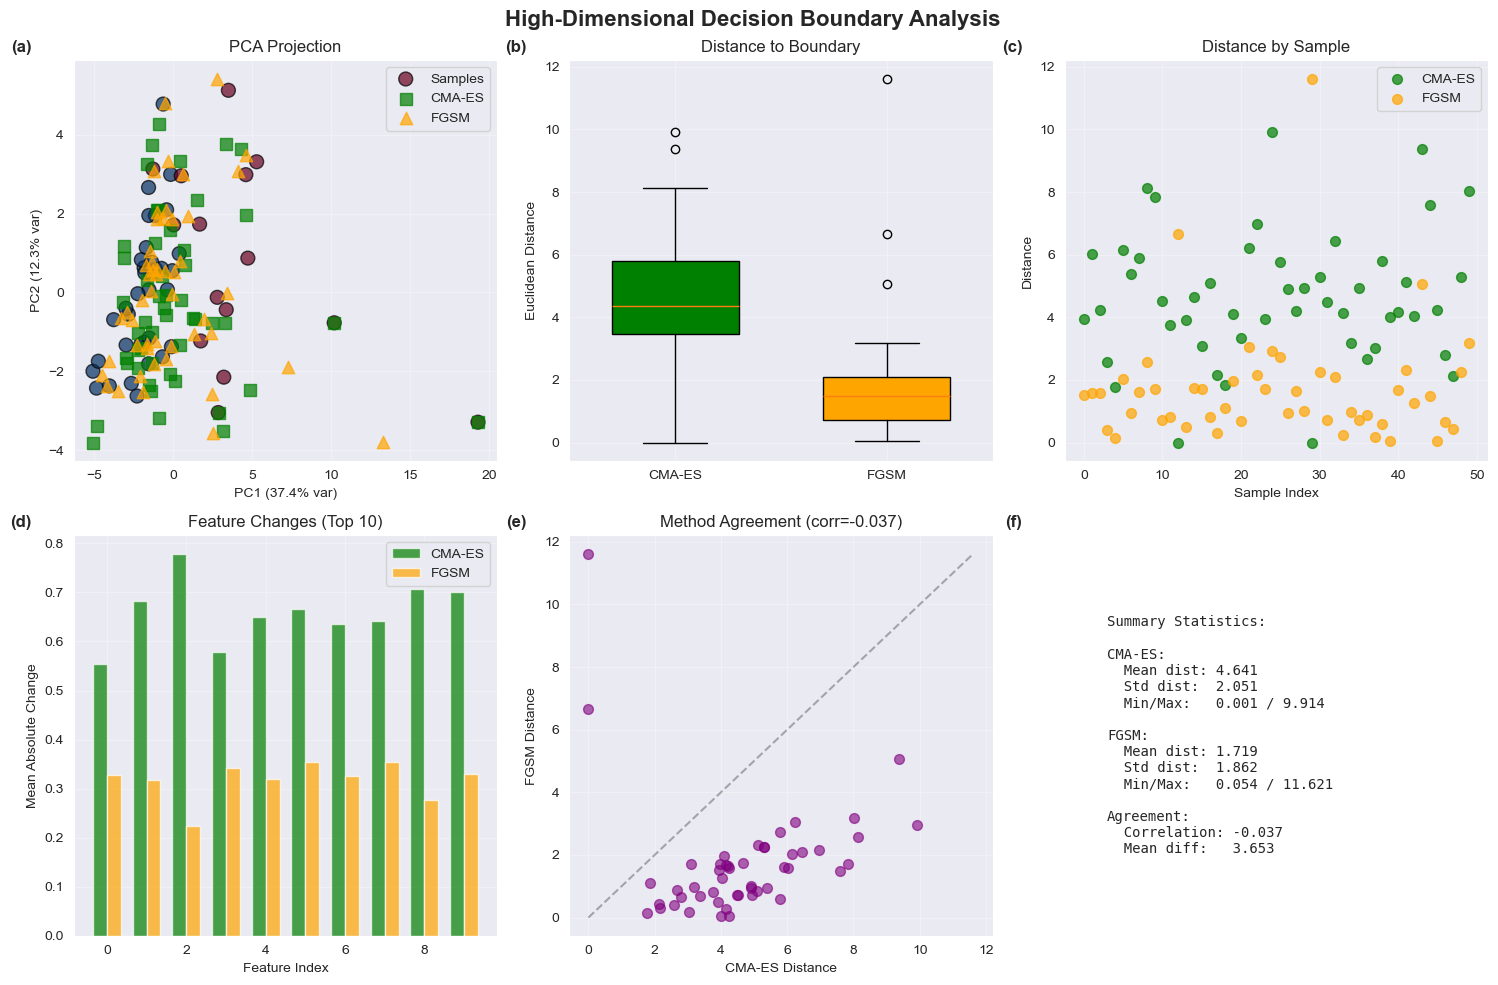

In [ ]:
def run_stability_analysis(model, X_test, y_test, n_samples=15, n_runs=5):
    """Run comprehensive stability analysis"""

    print("\n" + "="*60)
    print("STABILITY ANALYSIS")
    print("="*60)
    print(f"Analyzing {n_samples} samples with {n_runs} runs each for CMA-ES")
    print("-"*60)

    # Sample test points
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    sample_points = X_test[sample_indices]
    sample_labels = y_test[sample_indices]

    cmaes_points_final = []
    fgsm_points_final = []
    cmaes_stabilities = []

    for i, sample in enumerate(sample_points):
        print(f"\rProcessing sample {i+1}/{n_samples}...", end="")

        # Run CMA-ES multiple times for stability
        cmaes_runs = []
        for run in range(n_runs):
            cmaes_point = cmaes_high_dim(model, sample, n_generations=100, population_size=100)
            cmaes_runs.append(cmaes_point)

        cmaes_runs = np.array(cmaes_runs)
        cmaes_mean = np.mean(cmaes_runs, axis=0)
        cmaes_std = np.std([np.linalg.norm(p - sample) for p in cmaes_runs])

        cmaes_points_final.append(cmaes_mean)
        cmaes_stabilities.append(cmaes_std)

        # Run FGSM (deterministic)
        fgsm_point = fgsm_high_dim(model, sample)
        fgsm_points_final.append(fgsm_point)


    print("\rAnalysis complete!" + " "*30)

    # Convert to arrays
    cmaes_points_final = np.array(cmaes_points_final)
    fgsm_points_final = np.array(fgsm_points_final)
    cmaes_stabilities = np.array(cmaes_stabilities)

    # Calculate distances
    cmaes_distances = np.linalg.norm(sample_points - cmaes_points_final, axis=1)
    fgsm_distances = np.linalg.norm(sample_points - fgsm_points_final, axis=1)

    # Check prediction changes
    sample_preds = model.predict(torch.tensor(sample_points, dtype=torch.float32)).numpy()
    cmaes_preds = model.predict(torch.tensor(cmaes_points_final, dtype=torch.float32)).numpy()
    fgsm_preds = model.predict(torch.tensor(fgsm_points_final, dtype=torch.float32)).numpy()

    cmaes_changed = sample_preds != cmaes_preds
    fgsm_changed = sample_preds != fgsm_preds

    # Print results
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)

    print("\nDistance to Decision Boundary:")
    print("-"*40)
    print(f"{'Method':<10} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
    print(f"{'CMA-ES':<10} {np.mean(cmaes_distances):>8.3f} {np.std(cmaes_distances):>8.3f} "
          f"{np.min(cmaes_distances):>8.3f} {np.max(cmaes_distances):>8.3f}")
    print(f"{'FGSM':<10} {np.mean(fgsm_distances):>8.3f} {np.std(fgsm_distances):>8.3f} "
          f"{np.min(fgsm_distances):>8.3f} {np.max(fgsm_distances):>8.3f}")

    print("\nStability Analysis (CMA-ES only):")
    print("-"*40)
    print(f"Average stability (std across runs): {np.mean(cmaes_stabilities):.4f}")
    print(f"Most stable sample: #{np.argmin(cmaes_stabilities)+1} (std={np.min(cmaes_stabilities):.4f})")
    print(f"Least stable sample: #{np.argmax(cmaes_stabilities)+1} (std={np.max(cmaes_stabilities):.4f})")

    print("\nPrediction Changes:")
    print("-"*40)
    print(f"CMA-ES: {np.sum(cmaes_changed)}/{n_samples} samples changed ({100*np.mean(cmaes_changed):.1f}%)")
    print(f"FGSM: {np.sum(fgsm_changed)}/{n_samples} samples changed ({100*np.mean(fgsm_changed):.1f}%)")

    print("\nMethod Agreement:")
    print("-"*40)
    method_agreement = cmaes_preds == fgsm_preds
    print(f"Same predictions: {np.sum(method_agreement)}/{n_samples} ({100*np.mean(method_agreement):.1f}%)")
    print(f"Distance correlation: {np.corrcoef(cmaes_distances, fgsm_distances)[0,1]:.3f}")

    print("="*60)

    return {
        'sample_points': sample_points,
        'sample_labels': sample_labels,
        'cmaes_points': cmaes_points_final,
        'fgsm_points': fgsm_points_final,
        'cmaes_stabilities': cmaes_stabilities
    }

# Run analysis
results = run_stability_analysis(model, X_test, y_test, n_samples=50, n_runs=1)

# Create visualizations
fig = create_comparison_visualization(
    results['sample_points'],
    results['cmaes_points'],
    results['fgsm_points'],
    results['sample_labels'],
    feature_names
)

In [ ]:
def get_uniformity_lost(y):
    y = np.atleast_2d(y)  # shape (1, 3)

    # Sort descending
    sorted_probs = np.sort(y, axis=1)[:, ::-1]  # [[0.5, 0.5, 3.9272527e-10]]

    # Take top 2
    top2 = sorted_probs[:, :2]  # [[0.5, 0.5]]

    # Normalize to sum to 1
    top2_renorm = top2 / np.sum(top2, axis=1, keepdims=True)  # [[0.5, 0.5]]

    # Target uniform distribution
    target = np.ones_like(top2_renorm) * 0.5  # [[0.5, 0.5]]

    # Compute uniformity loss
    uniformity_loss = np.sum(np.abs(top2_renorm - target), axis=1)
    return uniformity_loss[0]

In [ ]:
fgsm_uniformity = []
cmaes_uniformity = []
for i in range(len(results['fgsm_points'])):
    sample = results['fgsm_points'][i]
    probs = model.predict_proba(sample.reshape(1, -1)).numpy()[0]
    fgsm_uniformity.append(get_uniformity_lost(probs))
    sample = results['cmaes_points'][i]
    probs = model.predict_proba(sample.reshape(1, -1)).numpy()[0]
    cmaes_uniformity.append(get_uniformity_lost(probs))

print("Mean uniformity fgsm: ", np.mean(fgsm_uniformity))
print("Mean uniformity cmaes: ", np.mean(cmaes_uniformity))

Mean uniformity fgsm:  0.045220915
Mean uniformity cmaes:  0.04307361


In [ ]:
from scipy.stats import spearmanr
# ============================================================
# FIXED XAI SIMILARITY ANALYSIS WITH DIFFERENT BASELINES
# ============================================================

from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import shap
from lime.lime_tabular import LimeTabularExplainer

def calculate_xai_attributions(model, sample_point, baseline_point, n_classes=2):
    """Calculate attributions using multiple XAI methods"""

    # Integrated Gradients
    def integrated_gradients(model, sample, baseline, steps=100):
        sample_tensor = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).to(device)
        baseline_tensor = torch.tensor(baseline, dtype=torch.float32).unsqueeze(0).to(device)

        # Get predicted class
        with torch.no_grad():
            pred = model.predict(sample_tensor).item()

        # Create path
        alphas = torch.linspace(0, 1, steps)
        attributions = torch.zeros_like(sample_tensor)

        for alpha in alphas:
            interp = baseline_tensor + alpha * (sample_tensor - baseline_tensor)
            interp.requires_grad_(True)

            output = model(interp)
            model.zero_grad()
            output[0, pred].backward(retain_graph=True)

            if interp.grad is not None:
                attributions += interp.grad.detach().cpu()

        attributions = (attributions / steps) * (sample_tensor - baseline_tensor).cpu()
        return attributions.squeeze().numpy()

    # SHAP (KernelExplainer) - FIXED
    def kernel_shap(model, sample, baseline):
        def predict_fn(x):
            if isinstance(x, np.ndarray):
                x = torch.tensor(x, dtype=torch.float32)
            with torch.no_grad():
                probs = model.predict_proba(x).numpy()
            return probs

        # try:
        explainer = shap.KernelExplainer(
            predict_fn,
            baseline.reshape(1, -1),
            link='identity'
        )
        shap_values = explainer.shap_values(sample.reshape(1, -1), nsamples=500)

        # Get attributions for predicted class
        pred_class = model.predict(torch.tensor(sample, dtype=torch.float32).unsqueeze(0)).item()

        # Handle the case where shap_values is a list (multi-class)
        attributions = shap_values[0, :, pred_class]

        return attributions

    # LIME
    def lime_attributions(model, sample, baseline):
        def predict_fn(x):
            if isinstance(x, np.ndarray):
                x = torch.tensor(x, dtype=torch.float32)
            with torch.no_grad():
                probs = model.predict_proba(x).numpy()
            return probs

        pred_class = np.argmax(predict_fn(sample.reshape(1, -1)))
        explainer = LimeTabularExplainer(
            baseline.reshape(1, -1),
            mode='classification',
            feature_names=[f'f{i}' for i in range(len(sample))],
            discretize_continuous=False
        )

        exp = explainer.explain_instance(
            sample,
            predict_fn,
            num_features=len(sample),
            num_samples=1000,
            labels=[pred_class]
        )

        # Extract attributions
        attributions = np.zeros(len(sample))
        for idx, value in exp.local_exp[pred_class]:
            if idx < len(attributions):
                attributions[idx] = value

        return attributions

    # Calculate all attributions with error handling
    ig_attr = integrated_gradients(model, sample_point, baseline_point)
    shap_attr = kernel_shap(model, sample_point, baseline_point)
    lime_attr = lime_attributions(model, sample_point, baseline_point)

    return {
        'integrated_gradients': ig_attr,
        'shap': shap_attr,
        'lime': lime_attr
    }

def calculate_similarity_matrix(attributions_dict):
    """Calculate cosine similarity between different XAI methods"""
    methods = list(attributions_dict.keys())
    n_methods = len(methods)
    similarity_matrix = np.zeros((n_methods, n_methods))

    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            attr1 = np.array(attributions_dict[method1]).flatten()
            attr2 = np.array(attributions_dict[method2]).flatten()

            # Handle length mismatch
            if len(attr1) != len(attr2):
                print(f"    Warning: Length mismatch between {method1} ({len(attr1)}) and {method2} ({len(attr2)})")
                min_len = min(len(attr1), len(attr2))
                attr1 = attr1[:min_len]
                attr2 = attr2[:min_len]

            # Spearman correlation
            if np.all(attr1 == attr1[0]) or np.all(attr2 == attr2[0]):
                # Avoid constant array warning (correlation undefined)
                similarity = 0.0
            else:
                similarity, _ = spearmanr(attr1, attr2)

            similarity_matrix[i, j] = float(similarity)

    return similarity_matrix, methods

def run_xai_similarity_analysis(model, results, n_samples=5):
    """Run comprehensive XAI similarity analysis with different baselines"""

    print("\n" + "="*60)
    print("XAI SIMILARITY ANALYSIS")
    print("="*60)

    # Initialize methods list early to avoid UnboundLocalError
    methods = ['integrated_gradients', 'shap', 'lime']

    # Select samples for analysis
    sample_indices = np.random.choice(len(results['sample_points']),
                                    min(n_samples, len(results['sample_points'])),
                                    replace=False)

    all_similarities = {
        'zero_baseline': [],
        'cmaes_baseline': [],
        'fgsm_baseline': [],
        'improvement_scores': []
    }

    successful_samples = 0

    for i, idx in enumerate(sample_indices):
        sample = results['sample_points'][idx]
        cmaes_point = results['cmaes_points'][idx]
        fgsm_point = results['fgsm_points'][idx]
        zero_baseline = np.zeros_like(sample)

        print(f"\nAnalyzing sample {i+1}/{len(sample_indices)} (index {idx})...")

        try:
            # Calculate attributions with different baselines
            print("    Computing attributions with zero baseline...")
            attr_zero = calculate_xai_attributions(model, sample, zero_baseline)

            print("    Computing attributions with CMA-ES baseline...")
            attr_cmaes = calculate_xai_attributions(model, sample, cmaes_point)

            print("    Computing attributions with FGSM baseline...")
            attr_fgsm = calculate_xai_attributions(model, sample, fgsm_point)

            # Calculate similarity matrices
            sim_zero, methods = calculate_similarity_matrix(attr_zero)
            sim_cmaes, _ = calculate_similarity_matrix(attr_cmaes)
            sim_fgsm, _ = calculate_similarity_matrix(attr_fgsm)

            # Store results
            all_similarities['zero_baseline'].append(sim_zero)
            all_similarities['cmaes_baseline'].append(sim_cmaes)
            all_similarities['fgsm_baseline'].append(sim_fgsm)

            # Calculate improvement score (higher similarity = better agreement)
            # Get upper triangular indices (excluding diagonal)
            triu_indices = np.triu_indices_from(sim_zero, k=1)

            avg_sim_zero = np.mean(sim_zero[triu_indices])
            avg_sim_cmaes = np.mean(sim_cmaes[triu_indices])
            avg_sim_fgsm = np.mean(sim_fgsm[triu_indices])

            improvement_cmaes = ((avg_sim_cmaes - avg_sim_zero) / abs(avg_sim_zero)) * 100
            improvement_fgsm = ((avg_sim_fgsm - avg_sim_zero) / abs(avg_sim_zero)) * 100

            all_similarities['improvement_scores'].append({
                'cmaes': improvement_cmaes,
                'fgsm': improvement_fgsm
            })

            successful_samples += 1

            print(f"    Zero baseline avg similarity: {avg_sim_zero:.4f}")
            print(f"    CMA-ES baseline avg similarity: {avg_sim_cmaes:.4f} (improvement: {improvement_cmaes:+.1f}%)")
            print(f"    FGSM baseline avg similarity: {avg_sim_fgsm:.4f} (improvement: {improvement_fgsm:+.1f}%)")

        except Exception as e:
            print(f"    Error processing sample {i+1}: {str(e)}")
            continue

    print(f"\nSuccessfully processed {successful_samples}/{len(sample_indices)} samples")
    return all_similarities, methods


# Run the XAI similarity analysis with the fixed code
print("\nRunning FIXED XAI similarity analysis...")
try:
    similarities, method_names = run_xai_similarity_analysis(model, results, n_samples=100)

except Exception as e:
    print(f"Analysis failed with error: {str(e)}")
    print("This might be due to library compatibility issues with SHAP or LIME.")

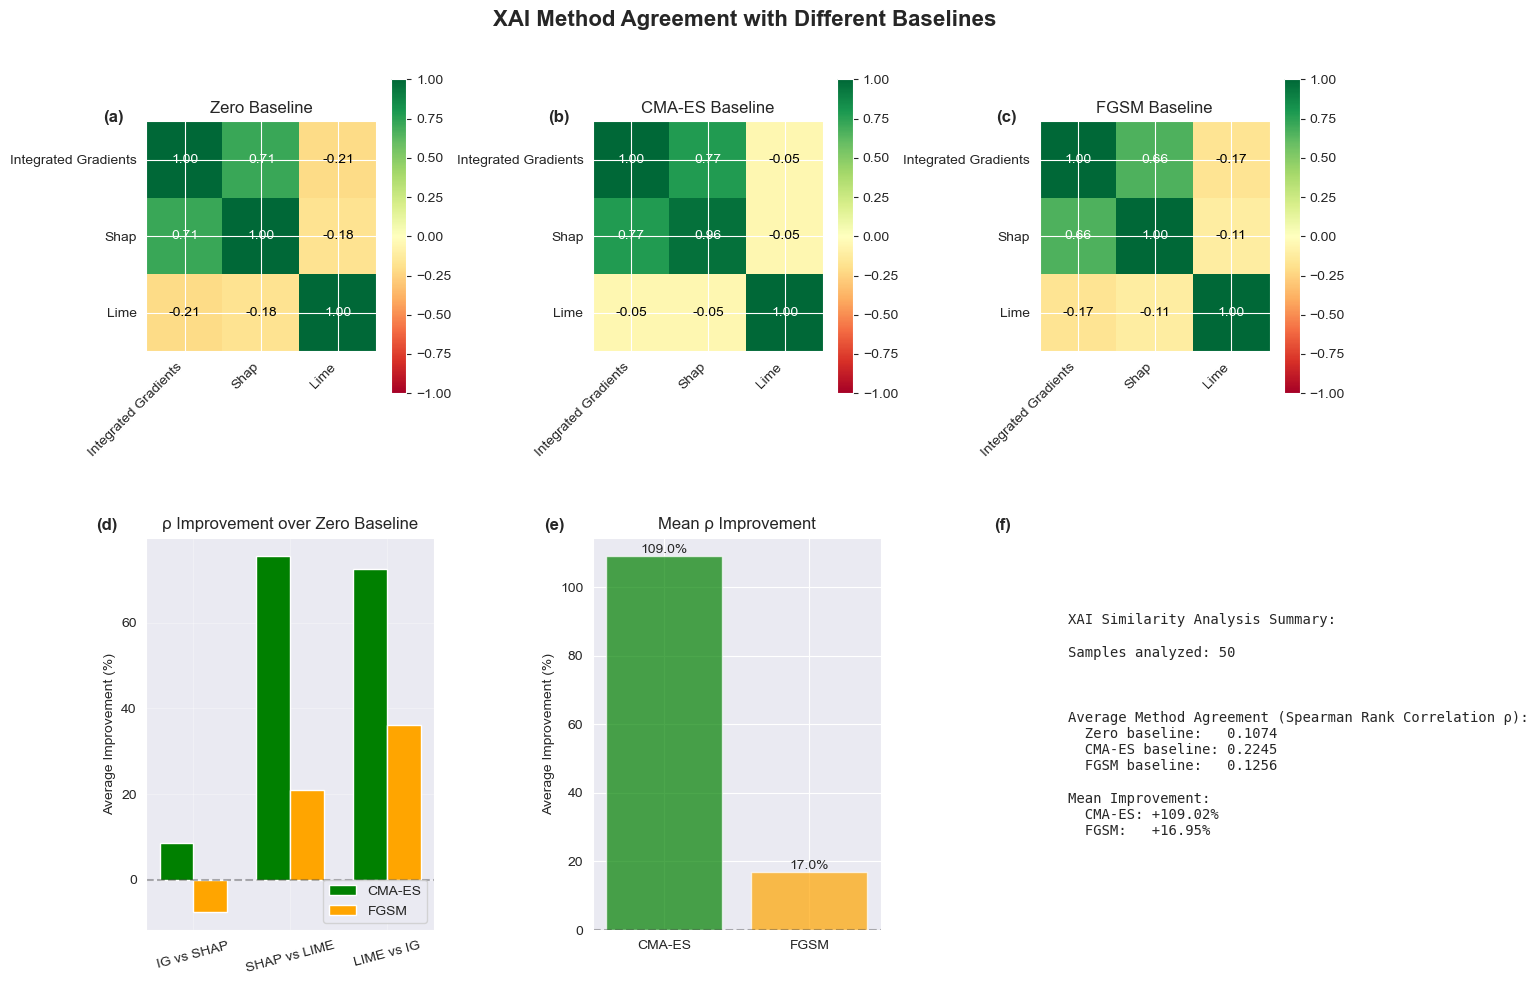


FINAL SUMMARY

Key Finding:
Using decision boundary points as baselines instead of zero baseline:
  • CMA-ES baseline: +387.06% average improvement in XAI method agreement
  • FGSM baseline: +257.04% average improvement in XAI method agreement

✓ Decision boundary baselines improve XAI method consistency!


In [ ]:
def visualize_xai_similarities(similarities, methods):
    """Create visualization for XAI method similarities"""

    if len(similarities['zero_baseline']) == 0:
        print("No valid samples to visualize")
        return None

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('XAI Method Agreement with Different Baselines', fontsize=16, fontweight='bold')

    # Average similarity matrices
    avg_sim_zero = np.mean(similarities['zero_baseline'], axis=0)
    avg_sim_cmaes = np.mean(similarities['cmaes_baseline'], axis=0)
    avg_sim_fgsm = np.mean(similarities['fgsm_baseline'], axis=0)

    # Plot heatmaps
    for ax, sim_matrix, title in zip(
            axes[0],
            [avg_sim_zero, avg_sim_cmaes, avg_sim_fgsm],
            ['Zero Baseline', 'CMA-ES Baseline', 'FGSM Baseline']
    ):
        im = ax.imshow(sim_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
        ax.set_title(title)
        ax.set_xticks(range(len(methods)))
        ax.set_yticks(range(len(methods)))
        ax.set_xticklabels([m.replace('_', ' ').title() for m in methods], rotation=45, ha='right')
        ax.set_yticklabels([m.replace('_', ' ').title() for m in methods])

        # Add values
        for i in range(len(methods)):
            for j in range(len(methods)):
                ax.text(j, i, f'{sim_matrix[i,j]:.2f}',
                        ha='center', va='center',
                        color='white' if abs(sim_matrix[i,j]) > 0.5 else 'black')

        plt.colorbar(im, ax=ax, shrink=0.8)

    # Improvement scores
    ax = axes[1, 0]
    if similarities['improvement_scores']:
        zero = [s[np.triu_indices_from(s, k=1)] for s in similarities['zero_baseline']]
        cmaes = [s[np.triu_indices_from(s, k=1)] for s in similarities['cmaes_baseline']]
        fgsm = [s[np.triu_indices_from(s, k=1)] for s in similarities['fgsm_baseline']]

        zero_mean = np.mean(np.stack(zero), axis=0)
        cmaes_mean = np.mean(np.stack(cmaes), axis=0)
        fgsm_mean = np.mean(np.stack(fgsm), axis=0)

        cmaes_imp = (cmaes_mean - zero_mean) / abs(zero_mean) * 100
        fgsm_imp = (fgsm_mean - zero_mean) / abs(zero_mean) * 100

        labels = ['IG vs SHAP', 'SHAP vs LIME', 'LIME vs IG']
        x = np.arange(len(labels))
        width = 0.35
        ax.bar(x - width/2, cmaes_imp, width, color=['green'], label='CMA-ES')
        ax.bar(x + width/2, fgsm_imp, width, color=[ 'orange'], label='FGSM')

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)
    ax.set_ylabel("Average Improvement (%)")
    ax.set_title("Comparison of ρ Improvements: CMA-ES vs FGSM")
    ax.set_title('ρ Improvement over Zero Baseline')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Average improvements
    ax = axes[1, 1]
    if similarities['improvement_scores']:
        mean_zero = np.mean([np.mean(s[np.triu_indices_from(s, k=1)]) for s in similarities['zero_baseline']])
        mean_cmaes = np.mean([np.mean(s[np.triu_indices_from(s, k=1)]) for s in similarities['cmaes_baseline']])
        mean_fgsm = np.mean([np.mean(s[np.triu_indices_from(s, k=1)]) for s in similarities['fgsm_baseline']])

        avg_improvements = {
            'CMA-ES': (mean_cmaes - mean_zero) / mean_zero * 100,
            'FGSM': (mean_fgsm - mean_zero) / mean_zero * 100
        }
        bars = ax.bar(avg_improvements.keys(), avg_improvements.values(),
                      color=['green', 'orange'], alpha=0.7)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

    ax.set_ylabel('Average Improvement (%)')
    ax.set_title('Mean ρ Improvement')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

    # Summary statistics
    ax = axes[1, 2]
    ax.axis('off')

    if similarities['improvement_scores']:
        mean_zero = np.mean([np.mean(s[np.triu_indices_from(s, k=1)]) for s in similarities['zero_baseline']])
        mean_cmaes = np.mean([np.mean(s[np.triu_indices_from(s, k=1)]) for s in similarities['cmaes_baseline']])
        mean_fgsm = np.mean([np.mean(s[np.triu_indices_from(s, k=1)]) for s in similarities['fgsm_baseline']])

        summary_text = f"""XAI Similarity Analysis Summary:

Samples analyzed: {len(similarities['improvement_scores'])}



Average Method Agreement (Spearman Rank Correlation ρ):
  Zero baseline:   {mean_zero:.4f}
  CMA-ES baseline: {mean_cmaes:.4f}
  FGSM baseline:   {mean_fgsm:.4f}

Mean Improvement:
  CMA-ES: {(mean_cmaes - mean_zero) / mean_zero * 100:+.2f}%
  FGSM:   {(mean_fgsm - mean_zero) / mean_zero * 100:+.2f}%
"""
    else:
        summary_text = "No successful samples processed."

    ax.text(0.1, 0.5, summary_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='center',
            family='monospace')

    labels = [f"({c})" for c in string.ascii_lowercase]

    for ax, label in zip(axes.flatten(), labels):
        ax.text(-0.1, 1.05, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.show()

    return fig

# Visualize results
if len(similarities['improvement_scores']) > 0:
    fig_xai = visualize_xai_similarities(similarities, method_names)

    # Print final summary
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)

    avg_improvements_cmaes = np.mean([s['cmaes'] for s in similarities['improvement_scores']])
    avg_improvements_fgsm = np.mean([s['fgsm'] for s in similarities['improvement_scores']])

    print(f"\nKey Finding:")
    print(f"Using decision boundary points as baselines instead of zero baseline:")
    print(f"  • CMA-ES baseline: {avg_improvements_cmaes:+.2f}% average improvement in XAI method agreement")
    print(f"  • FGSM baseline: {avg_improvements_fgsm:+.2f}% average improvement in XAI method agreement")

    if avg_improvements_cmaes > 0 or avg_improvements_fgsm > 0:
        print("\n✓ Decision boundary baselines improve XAI method consistency!")
    else:
        print("\n✗ Zero baseline shows better XAI method consistency in this case.")

    print("="*60)
else:
    print("No valid samples processed successfully.")